# Kaggle上的titanic disaster数据分类问题

**题目信息：**
* 这是一个二分类问题，根据旅客的信息判断旅客是否可以在这场灾难中存活下来`(0 = No, 1 = Yes)`
* 存活下来除了有运气的成分之外，有一些人更有可能存活下来：`women`、`children`、`the upper-class`

### 目录

- 1. [数据处理](#1)
    - 1.1 [Import](#1.1)
    - 1.2 [加载数据](#1.2)
    - 1.3 [处理离群点](#1.3)
    - 1.4 [处理缺失值](#1.4)
    <p></p>
    
- 2. [对数据进行探索性分析](#2)
    <p></p>
    
- 3. [特征工程和特征选择](#3)
    - 3.1 [特征工程](#3.1)
    - 3.2 [特征选择（去除共线特征）](#3.2)
    - 3.3 [特征缩放](#3.3)
    - 3.4 [划分训练集、验证集](#3.4)
    <p></p>
    
- 4. [基于性能指标比较几种机器学习模型](#4)
    - 4.1 [建立Baseline](#4.1)
    - 4.2 [使用默认参数、交叉验证对比模型](#4.2)
    - 4.3 [在参数空间中随机进行参数搜索，对比模型](#4.3)
    - 4.4 [绘制模型的学习曲线](#4.4)
    - 4.5 [使用网格搜索进一步进行参数搜索](#4.5)
    <p></p>
    
- 5. [评估最终模型](#5)
    - 5.1 [在验证集上评估模型](#5.1)
    - 5.2 [生成测试集上的分类结果](#5.2)
    <p></p>
    
- [参考文献](#references)  

#  1. 数据处理<span id = "1"></span>

## 1.1 Import<span id = "1.1"></span>
引入各个需要使用到的库。
使用`pandas`用来加载数据，对数据进行删改；使用`matplotlib.pyplot`和`seaborn`对数据进行可视化；使用`sklearn`中提供的模型来拟合训练数据。

In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size']=24

from IPython.core.pylabtools import figsize

import seaborn as sns
sns.set(font_scale=1.5)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from collections import Counter

## 1.2 加载数据<span id = "1.2"></span>
使用`read_csv`来加载数据，使用`head`函数可以打印数据表中的前几行，以初步了解数据的组成。

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


下面是表中数据每一字段的具体含义，从[kaggle titanic 竞赛主页](https://www.kaggle.com/c/titanic/data)得到。题目中的Overview中提到了，women、children、the upper-class存活下来的概率更大，所以接下来，我们可能要更加注重pclass、sex、age这三个字段。

| Tables        | Are           | Cool  |
| ------------- |:-------------:| -----:|
|survival	|Survival	|0 = No, 1 = Yes|
|pclass	|Ticket class	|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex	|Sex	|
|Age	|Age in years|	
|sibsp	|# of siblings / spouses aboard the Titanic	|
|parch	|# of parents / children aboard the Titanic	|
|ticket	|Ticket number	|
|fare	|Passenger fare	|
|cabin	|Cabin number	|
|embarked	|Port of Embarkation	|C = Cherbourg, Q = Queenstown, S = Southampton|



使用`info()`函数可以了解各个字段所使用的数据类型，如果遇到数字类型存储为`object`类型的，在接下来的处理中需要进行类型转换。可以看到，所有的列都使用了正确的数据类型，并没有出现包含数字的列被存储为`object`类型。

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## 1.3 处理离群点<span id = "1.3"></span>

检查训练数据中是否存在离群点，离群点可能是由于输入错误，计算错误造成的。离群点可能对模型的训练产生很大的影响。使用Tukey方法检测异常值，先计算某一个特征的第一四分位数`Q1`和第三四分位数`Q3`，四分位距`IQR=Q3-Q1`，将`outlier_step`设置为`1.5×IQR`，异常值就是在`[Q1-outlier_step, Q3+outlier_step]`范围之外的数。

In [4]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
outliers_to_drop = detect_outliers(train_data, 2, ["Age","SibSp","Parch","Fare"])

c:\myprogram\python35\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


使用`detect_outliers`检测训练数据`Age`、`SibSp`、`Parch`、`Fare`这四个字段中的离群点，并将用来两个以上的离群点的乘客信息打印出来

In [5]:
train_data.loc[outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S


将这些乘客信息（离群点）从训练数据中删除

In [6]:
train_data = train_data.drop(outliers_to_drop, axis=0).reset_index(drop=True)

## 1.4 处理缺失值<span id = "1.4"></span>
查看各个字段中是否存在有缺失值，如果某一字段中存在有缺失值，若缺失项过多，则将该字段删除，如果缺失项不多，则可以使用该字段的中位数或频数最高的项进行填充。

In [7]:
print('Train columns with null values:\n', train_data.isnull().sum() / train_data.shape[0])
print("-"*10)

print('Test/Validation columns with null values:\n', test_data.isnull().sum() / test_data.shape[0])
print("-"*10)

Train columns with null values:
 PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.192963
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771850
Embarked       0.002270
dtype: float64
----------
Test/Validation columns with null values:
 PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64
----------


从上面的统计信息可以看出，`Age`、`Embarked`和`Fare`字段中均存在缺失项（`null`）。对于`Age`和`Fare`的缺失项使用它们的中值进行填充，对于`Embarked`使用其中频数出现最多的项进行填充。而`Cabin`、`PassengerId`和`Ticker`分别是船舱号、乘客序号和票序号，对于每个从乘客都是不同的，却对于分类没有帮助，在这里进行了删除。

In [8]:
# data filed has been changed
for dataset in [train_data, test_data]:    
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
drop_column = ['Cabin','PassengerId', 'Ticket']
train_data.drop(drop_column, axis=1, inplace = True)

test_data_passengerId = test_data['PassengerId']
test_data.drop(drop_column, axis=1, inplace = True)

print(train_data.isnull().sum())
print("-"*10)
print(test_data.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


# 2 对数据进行探索性分析<span id = "2"></span>

计算各个字段与最终分类结果的相关性，对于这个问题，最终的分类结果就是存活与否。使用`corr()`函数计算数据中的各个字段与`Survived`字段的相关性。

In [73]:
correlations_matrix = train_data.corr()['Survived'].sort_values()
print(correlations_matrix, '\n')

Sex_Code        -0.546015
Pclass          -0.334097
IsAlone         -0.211448
Embarked_Code   -0.166252
Title_Code      -0.085881
AgeBin_Code     -0.046264
FamilySize       0.055279
Fare             0.264613
FareBin_Code     0.308450
Survived         1.000000
Name: Survived, dtype: float64 



从上面的相关性可以看出，乘客的座位等级、票价、性别与存活与否有较大的相关性。

更加详细地，可以查看各个字段（非浮点数类型的字段）的取值与`Survived`字段的相关性。

In [10]:
for x in train_data:
    if train_data[x].dtype != 'float64' and x not in ['Survived', 'Name']:
        print('Survival Correlation by:', x)
        print(train_data[[x, 'Survived']].groupby(x, as_index=False).mean())
        print('-' * 10, '\n')

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629108
1       2  0.472826
2       3  0.245868
---------- 

Survival Correlation by: Sex
      Sex  Survived
0  female  0.747573
1    male  0.190559
---------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.153846
4      4  0.166667
5      5  0.000000
---------- 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.542857
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.341195
---------- 



* 对于`Pclass`字段来说，一等座的乘客存活的概率比较大
* 对于`Sex`字段来说，女性存活的概率比男性大
* 对于`SilSp`字段来说，有越多的`siblings/spouses`存活的概率越小，有0-2个`siblings/spouses`存活的概率比较大
* 对于`Parch`字段来说，有越多的`parents/children`数量存活概率越小，有0-3个`parents/children`的存活概率比较大
* 对于`Embarked`字段来说，来自`Cherbourg`的乘客存活的概率更大

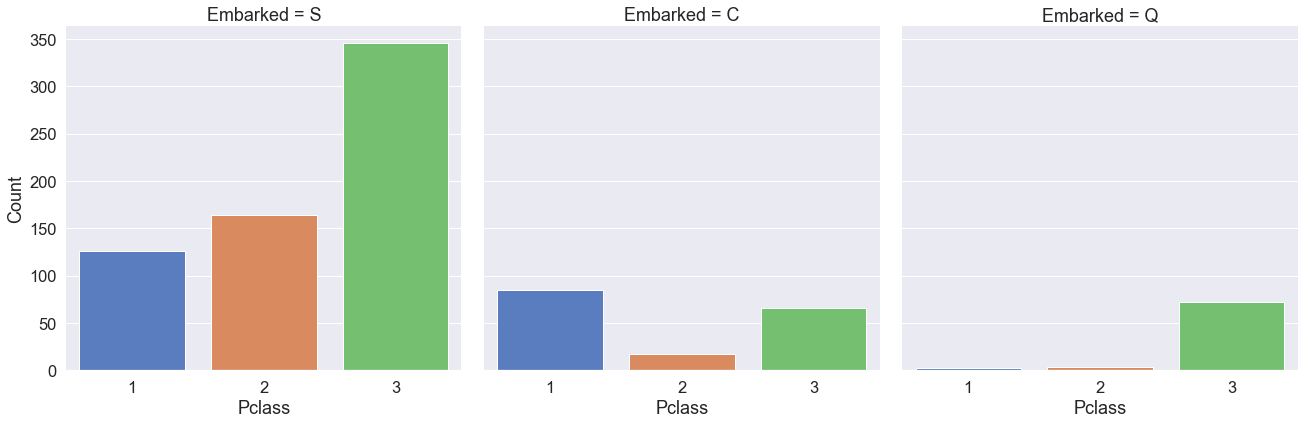

In [11]:
graph = sns.catplot("Pclass", col="Embarked",  data=train_data, height=6, kind="count", palette="muted")
graph.despine(left=True)
graph = graph.set_ylabels("Count")

从上面的图标可以看出，来自`Cherbourg`的乘客中大部分的乘客是一等座，因此来自`Cherbourg`的乘客拥有更高的存活率。

# 3. 特征工程与特征选择<span id="3"></span>

## 3.1 特征工程<span id = "3.1"></span>
使用特征工程来从现有的数据中创造新的特征，以提高模型的性能。创造出新的特征并不知道这个特征是否有用，需要到后面进行测试验证的时候，才可以看到成果，然后根据结果可以继续进行创造修改，这是一个迭代往复的过程。

In [12]:
# data filed has been changed
def create_features_for_data(data):
    data['FamilySize'] = data ['SibSp'] + data['Parch'] + 1
    
    data['IsAlone'] = 1
    data['IsAlone'].loc[data['FamilySize'] > 1] = 0 
    
    data['Title'] = data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    title_names = (data['Title'].value_counts() < 10) 
    data['Title'] = data['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
    
    data['FareBin'] = pd.qcut(data['Fare'], 4)
    data['AgeBin'] = pd.cut(data['Age'].astype(int), 5)
    
    label = LabelEncoder()
    features = ['Sex', 'Embarked', 'Title', 'FareBin', 'AgeBin']
    for f in features:
        data[f+'_Code'] = label.fit_transform(data[f])
    
    data = data.drop(columns=['Sex', 'Embarked', 'Title', 'FareBin', 'AgeBin', 'Name'])
    return data

train_data = create_features_for_data(train_data)
test_data = create_features_for_data(test_data)
print('train data shape:',train_data.shape)
train_data.head(5)

train data shape: (881, 13)


,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Sex_Code,Embarked_Code,Title_Code,FareBin_Code,AgeBin_Code
0,0,3,22.0,1,0,7.2500,2,0,1,2,3,0,1
1,1,1,38.0,1,0,71.2833,2,0,0,0,4,3,2
2,1,3,26.0,0,0,7.9250,1,1,0,2,2,1,1
3,1,1,35.0,1,0,53.1000,2,0,0,2,4,3,2
4,0,3,35.0,0,0,8.0500,1,1,1,2,3,1,2


## 3.2 特征选择（去除共线特征）<span id = "3.2"></span>
在训练模型的过程中，共线特征对包含的信息是大部分重叠的，造成了信息冗余。这些共线特征对于提升模型性能帮助不大，但是冗余信息会增大计算量，还可能会使得性能降低，所以在这里删除共线特征。

使用下面的函数来统计共线特征，这个函数来自参考文献[1]，我对其进行了修改，删除了自动删除共线特征的部分，只剩下打印共线特征，然后由我来觉得删除那些共线特征。因为自动删除共线特征可能会删除掉一些重要的特征。

In [13]:
def print_collinear_features(x, threshold):
    '''
    Objective:
       删除数据帧中相关系数大于阈值的共线特征。 删除共线特征可以帮助模型泛化并提高模型的可解释性。
        
    Inputs: 
        阈值：删除任何相关性大于此值的特征
    
    Output: 
        仅包含非高共线特征的数据帧
    '''
    
    # 不要删除能源之星得分之间的相关性
    y = x['Survived']
    x = x.drop(columns = ['Survived'])
    
    # 计算相关性矩阵
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # 迭代相关性矩阵并比较相关性
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # 如果相关性超过阈值
            if val >= threshold:
                # 打印有相关性的特征和相关值
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])


In [14]:
print_collinear_features(train_data, 0.6)

FamilySize | SibSp | 0.85
FamilySize | Parch | 0.81
IsAlone | SibSp | 0.65
FareBin_Code | Pclass | 0.65
AgeBin_Code | Age | 0.94


可以看到，共线的特征有FamilySize/SibSp/Parch，FareBin_Code/Pclass，AgeBin_Code/Age这三组，将要删除的字段是Age、SibSp、Parch。

In [15]:
# data filed has been changed
drop_columns = ['Age', 'SibSp', 'Parch']
train_data = train_data.drop(columns=drop_columns)
test_data = test_data.drop(columns=drop_columns)
print('train data shape:',train_data.shape)
train_data.head(5)

train data shape: (881, 10)


,Survived,Pclass,Fare,FamilySize,IsAlone,Sex_Code,Embarked_Code,Title_Code,FareBin_Code,AgeBin_Code
0,0,3,7.2500,2,0,1,2,3,0,1
1,1,1,71.2833,2,0,0,0,4,3,2
2,1,3,7.9250,1,1,0,2,2,1,1
3,1,1,53.1000,2,0,0,2,4,3,2
4,0,3,8.0500,1,1,1,2,3,1,2


## 3.3 特征缩放<span id = "3.3"></span>

不同的方法对特征缩放的敏感程度不一样，如决策树对特征缩放不敏感，而支持向量机对特征缩放比较敏感。为了在下文对不同模型进行较为公平的比较，在这里统一对数据进行缩放，将连续变量的数值范围缩放在`[0,1]`之间。

In [16]:
max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
train_data[['Fare']] = train_data[['Fare']].apply(max_min_scaler)
test_data[['Fare']] = test_data[['Fare']].apply(max_min_scaler)
train_data.head(5)

,Survived,Pclass,Fare,FamilySize,IsAlone,Sex_Code,Embarked_Code,Title_Code,FareBin_Code,AgeBin_Code
0,0,3,0.014151,2,0,1,2,3,0,1
1,1,1,0.139136,2,0,0,0,4,3,2
2,1,3,0.015469,1,1,0,2,2,1,1
3,1,1,0.103644,2,0,0,2,4,3,2
4,0,3,0.015713,1,1,1,2,3,1,2


## 3.4 划分训练集、验证集<span id = "3.4"></span>

In [17]:
targets = train_data[['Survived']]
features = train_data.drop(columns=['Survived'])

X_train, X_valid, Y_train, Y_valid = train_test_split(features, targets, test_size = 0.3, random_state = 42)

print('shape of X_train:', X_train.shape)
print('shape of Y_train:', Y_train.shape)
print('shape of X_valid:', X_valid.shape)
print('shape of Y_valid:', Y_valid.shape)

X_train.to_csv('X_train.csv', index=False)
Y_train.to_csv('Y_train.csv', index=False)

Y_train = np.array(Y_train).reshape((-1, ))
Y_valid = np.array(Y_valid).reshape((-1, ))

shape of X_train: (616, 9)
shape of Y_train: (616, 1)
shape of X_valid: (265, 9)
shape of Y_valid: (265, 1)


# 4 基于性能指标比较几种机器学习模型<span id='4'></span>

In [18]:
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn import model_selection
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
import scipy.stats
import json
from xgboost import XGBClassifier

## 4.1 建立Baseline<span id = "4.1"></span>

建立`baseline`用来与机器学习模型进行对比，看一下机器学习是否可以用于这个问题。由于分类结果中`Survived==0`的情况较多，在这里的`baseline`将所有的数据分类为`Survived=0`，在验证集上的准确率为`60.00%`。

In [19]:
baseline_accuracy = 1 - np.sum(Y_valid)/Y_valid.shape[0]
print('The baseline guess is %d' % 0)
print("Baseline Performance on the test set: accuracy = %0.4f" % baseline_accuracy)

The baseline guess is 0
Baseline Performance on the test set: accuracy = 0.6000


## 4.2 使用默认参数、交叉验证对比模型<span id = "4.2"></span>

现在还不知道该使用什么模型来进行训练，所以在下面列举了多个模型进行测试，根据测试的结果选择合适的模型。

In [20]:
# machine learning algorithm
classifiers = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(n_estimators=10),
    ensemble.BaggingClassifier(n_estimators=10),
    ensemble.ExtraTreesClassifier(n_estimators=10),
    ensemble.GradientBoostingClassifier(n_estimators=10),
    ensemble.RandomForestClassifier(n_estimators=10),

#     Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(cv=3, max_iter=1000),
    linear_model.PassiveAggressiveClassifier(max_iter=1000, tol=1e-3),
    linear_model.RidgeClassifierCV(cv=3),
    linear_model.SGDClassifier(max_iter=1000, tol=1e-3),
    linear_model.Perceptron(max_iter=1000, tol=1e-3),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True, gamma='scale'),
    svm.NuSVC(probability=True, gamma='scale'),
#     svm.LinearSVC(max_iter=1000),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    #xgboost
    XGBClassifier()
]

In [21]:
cv_results = pd.DataFrame(columns=['clasifier name', 'mean accuracy', 'accuracy std'])
row_index = 0
for model in classifiers:
    score = model_selection.cross_val_score(model, X_train, Y_train, scoring="accuracy", cv=10, n_jobs=4)
    cv_results.loc[row_index, 'clasifier name'] = model.__class__.__name__
    cv_results.loc[row_index, 'mean accuracy'] = score.mean()
    cv_results.loc[row_index, 'accuracy std'] = score.std()
    row_index += 1
cv_results.sort_values(by=['mean accuracy'], ascending=False, inplace=True)

Text(0,0.5,'Model')

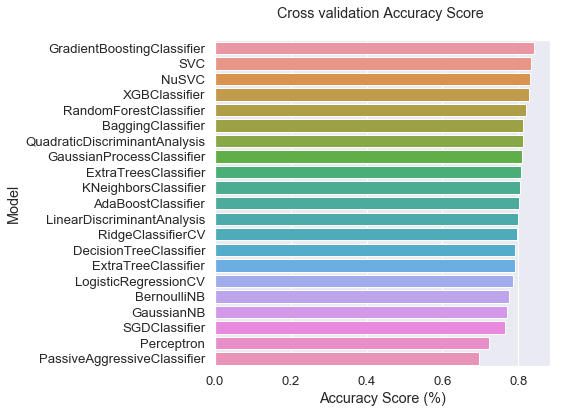

In [22]:
figsize(6,6)
sns.set(font_scale=1.2)
sns.barplot(x = 'mean accuracy', y = 'clasifier name', data=cv_results)
plt.title('Cross validation Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Model')

## 4.3 在参数空间中随机进行参数搜索，对比模型<span id = "4.3"></span>

接下来列举了一些可能会影响到模型分类准确率的参数，将会使用这些参数空间中进行搜索，为每个模型找到各自合适的参数。

In [23]:
# machine learning algorithm
classifiers = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(n_estimators=10),
    ensemble.BaggingClassifier(n_estimators=10),
    ensemble.ExtraTreesClassifier(n_estimators=10),
    ensemble.GradientBoostingClassifier(n_estimators=10),
    ensemble.RandomForestClassifier(n_estimators=10),
    
    #SVM
    svm.SVC(probability=True, gamma='scale'),

    #xgboost
    XGBClassifier()
]

In [53]:
learning_rate = scipy.stats.uniform(loc=0.01, scale=1.0-0.01)
ratio = scipy.stats.uniform(loc=0.1, scale=1.0-0.1)
min_samples_leaf = [1, 2, 4, 6, 8]
min_samples_split = [2, 4, 6, 10]
cv = [3, 5, None]
max_depth = [2, 4, 6, 8, 10, None]
max_features = ['auto', 'sqrt', 'log2', None]
bool_value = [True, False]

hyperparameter_list = [
    # AdaBoostClassifier
    {'n_estimators': scipy.stats.randint(low=10, high=1000), 'algorithm':['SAMME', 'SAMME.R'], 'learning_rate':learning_rate},
    
    # BaggingClassifier
    {'n_estimators': scipy.stats.randint(low=10, high=400), 'max_samples': ratio},
    
    # ExtraTreesClassifier
    {'n_estimators': scipy.stats.randint(low=10, high=500), 'criterion': ['gini', 'entropy'], 'max_depth': max_depth,
     'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'max_features':max_features},
    
    # GradientBoostingClassifier
    {'n_estimators': scipy.stats.randint(low=10, high=700), 'loss': ['deviance', 'exponential'], 'learning_rate': learning_rate,
     'criterion':['friedman_mse', 'mse', 'mae'], 'min_samples_split':min_samples_split, 'min_samples_leaf': min_samples_leaf,
    'max_depth':max_depth, 'max_features':max_features},
    
    # RandomForestClassifier
    {'n_estimators': scipy.stats.randint(low=10, high=300), 'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf,
     'min_samples_split': min_samples_split,'max_features': max_features, },
    
    # SVC
    {'C': [1, 2, 3, 4, 5], 'gamma': ratio, 'decision_function_shape': ['ovo', 'ovr'], 'probability': [True]},

    #XGBClassifier
    {'n_estimators': scipy.stats.randint(low=10, high=300), 'learning_rate': learning_rate, 'max_depth': [2,4,6,8,10]}
]

使用`sklearn`库中提供的`model_selection.RandomizedSearchCV`在参数空间中进行搜索，为各个模型找到各自测试交叉验证准确率最高的参数。对比各个模型在验证集上的分类准确率，以选择合适的模型。

In [54]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
random_cv_columns = ['model name', 'model parameters', 'model train accuracy mean', 'model test accuracy mean', 'model test accuracy std']
random_cv_compare = pd.DataFrame(columns=random_cv_columns)
best_model_list = []
row_index = 0
for model, param in zip(classifiers, hyperparameter_list):
    random_search = model_selection.RandomizedSearchCV(estimator=model, iid=False,
                                                       param_distributions=param,
                                                       cv=10, n_iter=25, scoring='accuracy',
                                                       n_jobs=-1, verbose=1,
                                                       return_train_score=True,
                                                       random_state=0)
    model_name = model.__class__.__name__
    print('random_search for: %s' % model_name)
    random_search.fit(X_train, Y_train)
    random_search_results = random_search.cv_results_
    best_index = random_search.best_index_
    random_cv_compare.loc[row_index, 'model name'] = model_name
    random_cv_compare.loc[row_index, 'model parameters'] = json.dumps(random_search.best_estimator_.get_params(), cls=NumpyEncoder)
    random_cv_compare.loc[row_index, 'model train accuracy mean'] = random_search_results['mean_train_score'][best_index]
    random_cv_compare.loc[row_index, 'model test accuracy mean'] = random_search_results['mean_test_score'][best_index]
    random_cv_compare.loc[row_index, 'model test accuracy std'] = random_search_results['std_test_score'][best_index]
    best_model_list.append(random_search.best_estimator_)
    row_index += 1
random_cv_compare.sort_values(by=['model test accuracy mean'], ascending=False, inplace=True)

random_search for: AdaBoostClassifier
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   27.8s finished


random_search for: BaggingClassifier
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   10.3s finished


random_search for: ExtraTreesClassifier
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


random_search for: GradientBoostingClassifier
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 235 out of 250 | elapsed:   40.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   44.2s finished


random_search for: RandomForestClassifier
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


random_search for: SVC
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


random_search for: XGBClassifier
Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    4.0s finished


In [55]:
random_cv_compare

,model name,model parameters,model train accuracy mean,model test accuracy mean,model test accuracy std
4,RandomForestClassifier,"{""verbose"": 0, ""oob_score"": false, ""max_featur...",0.860567,0.848667,0.053338
1,BaggingClassifier,"{""n_jobs"": null, ""verbose"": 0, ""base_estimator...",0.902598,0.847028,0.0550906
6,XGBClassifier,"{""learning_rate"": 0.1376370346783048, ""booster...",0.925324,0.84055,0.0597183
3,GradientBoostingClassifier,"{""n_iter_no_change"": null, ""learning_rate"": 0....",0.882915,0.837322,0.056497
2,ExtraTreesClassifier,"{""verbose"": 0, ""oob_score"": false, ""max_featur...",0.872652,0.837219,0.0689739
0,AdaBoostClassifier,"{""learning_rate"": 0.6117523620283131, ""n_estim...",0.836576,0.827669,0.044197
5,SVC,"{""tol"": 0.001, ""cache_size"": 200, ""decision_fu...",0.897544,0.826057,0.0626949


Text(0,0.5,'Algorithm')

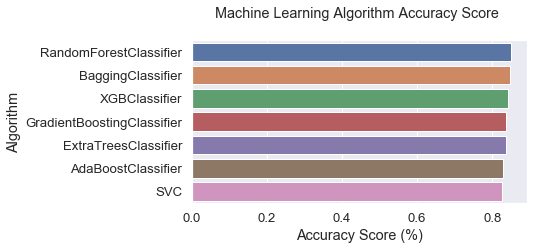

In [56]:
figsize(6,3)
sns.set(font_scale=1.2)
sns.barplot(x = 'model test accuracy mean', y = 'model name', data=random_cv_compare)
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

## 4.4 绘制模型的学习曲线<span id = "4.4"></span>

In [57]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = model_selection.learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

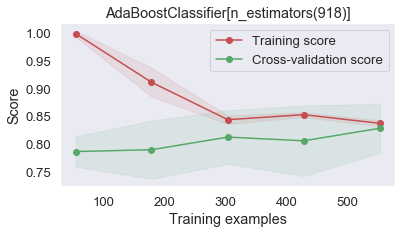

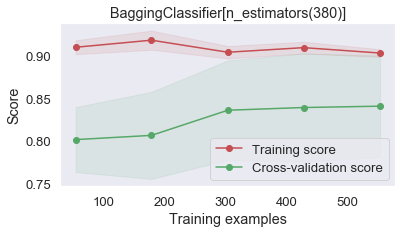

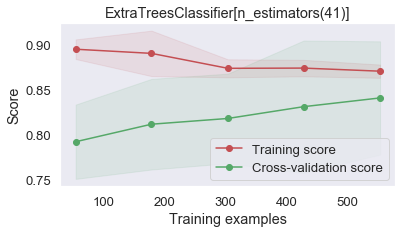

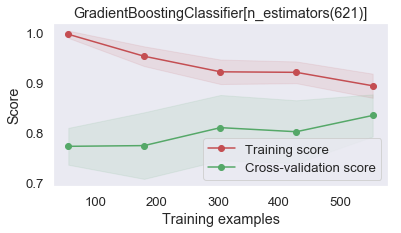

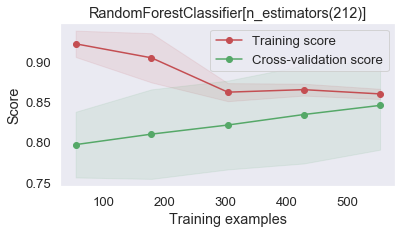

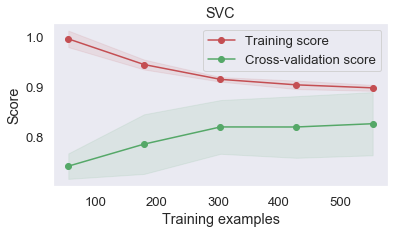

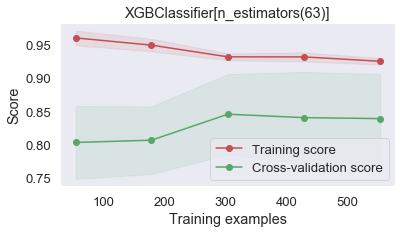

In [58]:
figsize(6, 3)
for best_model in best_model_list:
    model_name = best_model.__class__.__name__
    classifier_detail = random_cv_compare[random_cv_compare['model name'].isin([model_name])]
    params = json.loads(classifier_detail.iloc[0, 1])
    if 'n_estimators' in params:
        title = model_name + '[n_estimators(%d)]' % params['n_estimators']
    else:
        title = model_name
    plot_learning_curve(best_model, title, X_train, Y_train, cv=10)

## 4.5 使用网格搜索进一步进行参数搜索<span id = "4.5"></span>

根据上面随机搜索的结果，选择随机森林作为最终的模型，并使用`model_selection`中的`GridSearchCV`来进一步搜索参数。

In [60]:
classifier_name = 'RandomForestClassifier'
classifier_detail = random_cv_compare[random_cv_compare['model name'].isin([classifier_name])]
params = json.loads(classifier_detail.iloc[0, 1])
print(params)

{'max_leaf_nodes': None, 'class_weight': None, 'verbose': 0, 'max_features': None, 'bootstrap': True, 'min_samples_leaf': 1, 'random_state': None, 'min_samples_split': 10, 'oob_score': False, 'min_impurity_split': None, 'n_jobs': None, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'warm_start': False, 'min_impurity_decrease': 0.0, 'max_depth': 4, 'n_estimators': 212}


In [67]:
n_estimators = list(range(max(params['n_estimators']-50, 0), params['n_estimators']+50, 1))
hyperparameter_grid = {'n_estimators': n_estimators}

if classifier_name=='RandomForestClassifier':
    selected_classifier = ensemble.RandomForestClassifier(**params)
elif classifier_name=='XGBClassifier':
    selected_classifier = XGBClassifier(**params)
elif classifier_name=='GradientBoostingClassifier':
    selected_classifier = ensemble.GradientBoostingClassifier(**params)
elif classifier_name=='ExtraTreesClassifier':
    selected_classifier = ensemble.ExtraTreesClassifier(**params)
elif classifier_name=='AdaBoostClassifier':
    selected_classifier = ensemble.AdaBoostClassifier(**params)
else:
    raise RuntimeError('wrong classifier name')

grid_search = model_selection.GridSearchCV(estimator=selected_classifier,
                                           param_grid=hyperparameter_grid, 
                                           cv = 4, scoring='accuracy',
                                           verbose = 1,
                                           n_jobs = -1, 
                                           return_train_score = True)

In [68]:
grid_search.fit(X_train, Y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   16.1s finished
c:\myprogram\python35\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=212, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 2...242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261]},
       pre_dispatch='2*n_jobs', refit=True, return

In [69]:
grid_search_result = pd.DataFrame(grid_search.cv_results_).sort_values('mean_test_score', ascending = False)
best_mean_test_score = grid_search_result['mean_test_score'][0]
print('best mean test score of grid search result is %0.4f' % best_mean_test_score)

best mean test score of grid search result is 0.8458


In [70]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=162, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# 5. 评估最终模型<span id = "5"></span>

## 5.1 在验证集上评估模型<span id = "5.1"></span>

使用`GridSearchCV`搜索到的最佳随机森林来拟合数据，并计算其在验证集上的准确率。

In [71]:
def cal_accuracy(y_true, y_pred):
    return 1- np.sum(abs(y_true - y_pred)) / y_pred.shape[0]

# final_model = grid_search.best_estimator_
final_model = best_model_list[0]
final_pred = final_model.predict(X_valid)
accuracy = cal_accuracy(Y_valid, final_pred)
print('Final model performance on the test set:  accuracy = %0.4f.' % accuracy)

Final model performance on the test set:  accuracy = 0.8302.


## 5.2 生成测试集上的分类结果<span id = "5.2"></span>

In [72]:
test_label = final_model.predict(test_data)
test_result = pd.DataFrame(columns=['PassengerId', 'Survived'])
test_result['PassengerId'] = test_data_passengerId
test_result['Survived'] = test_label
test_result.head(5)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [37]:
test_result.to_csv('result.csv', index=False)

# 参考文献<span id="references"></span>

- [1]. [Predict a building's Energy Star score](https://github.com/DeqianBai/Your-first-machine-learning-Project---End-to-End-in-Python/blob/master/Predict%20a%20building's%20Energy%20Star%20score.ipynb)
- [2]. [A Data Science Framework: To Achieve 99% Accuracy](https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy)
- [3]. [Titanic Top 4% with ensemble modeling](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling)